In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install ftfy for fixing text encoding issues
!pip install -q ftfy

import pandas as pd
from ftfy import fix_text

# Load the previously uploaded CSV file
input_path = "/content/drive/MyDrive/test.csv"
output_path_cleaned = "/content/drive/MyDrive/test_cleaned.csv"

# Read CSV (attempt auto-detection of encoding and fix common issues)
df = pd.read_csv(input_path)

# Function to clean text: fix encoding, normalize whitespace, lowercase
def clean_text(text):
    if isinstance(text, str):
        fixed = fix_text(text)  # Fix mojibake and encoding
        fixed = fixed.lower()   # Lowercase
        fixed = ' '.join(fixed.split())  # Normalize whitespace
        return fixed
    return text

# Apply cleaning to all string columns
df_cleaned = df.applymap(clean_text)

# Save cleaned CSV
df_cleaned.to_csv(output_path_cleaned, index=False, encoding='utf-8')

output_path_cleaned


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.0 MB/s eta 0:00:00


<ipython-input-3-76764b897cbf>:24: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_cleaned = df.applymap(clean_text)


'/content/drive/MyDrive/test_cleaned.csv'

In [ ]:
import pandas as pd

# Load dataset
df = pd.read_csv("/content/drive/MyDrive/hate/data/test_cleaned_final.csv")
# Show basic info
print(df.columns)
print(df.head())


Index(['Offensive', 'Non-Offensive'], dtype='object')
                                           Offensive  \
0  i don't like this situation, you fat cow, just...   
1    that wasn't very kind, you shithead, just stop.   
2  everyone deserves respect, you retard, just stop.   
3    we should try to fix this, you jerk, just stop.   
4        that wasn't very kind, you slut, just stop.   

                                     Non-Offensive  
0  i don't want to talk like this. let's cool off.  
1   you're not helping the situation, so back off.  
2  i don't want to talk like this. let's cool off.  
3             let's end this conversation for now.  
4             let's end this conversation for now.  


In [ ]:
# Rename columns for clarity
df = df.rename(columns={"Offensive": "original_text", "Non-Offensive": "neutral_text"})

# Drop unused columns
df = df[["original_text", "neutral_text"]].dropna()

# Preview cleaned data
df.head()


,original_text,neutral_text
0,"i don't like this situation, you fat cow, just...",i don't want to talk like this. let's cool off.
1,"that wasn't very kind, you shithead, just stop.","you're not helping the situation, so back off."
2,"everyone deserves respect, you retard, just stop.",i don't want to talk like this. let's cool off.
3,"we should try to fix this, you jerk, just stop.",let's end this conversation for now.
4,"that wasn't very kind, you slut, just stop.",let's end this conversation for now.


In [ ]:
!pip install transformers datasets sentencepiece --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cu

In [ ]:
import pandas as pd
from datasets import Dataset

# Load cleaned data
#elects only two columns: Offensive (original) and Non-Offensive (target)
df = pd.read_csv("/content/drive/MyDrive/hate/data/test_cleaned_final.csv")[["Offensive", "Non-Offensive"]]
df = df.rename(columns={"Offensive": "original_text", "Non-Offensive": "neutral_text"}).dropna()#Removes rows with missing values in either column

df["original_text"] = "rephrase: " + df["original_text"]


dataset = Dataset.from_pandas(df[["original_text", "neutral_text"]])
dataset = dataset.train_test_split(test_size=0.1)  # 90% train, 10% test


In [ ]:
from transformers import AutoTokenizer
#5-small (60M params) - balanced between performance and efficiency
tokenizer = AutoTokenizer.from_pretrained("t5-small")

def tokenize(batch):
    return tokenizer(batch["original_text"], padding="max_length", truncation=True, max_length=128)#Fixed length 128 tokens

def tokenize_labels(batch):
    labels = tokenizer(batch["neutral_text"], padding="max_length", truncation=True, max_length=128)
    batch["labels"] = labels["input_ids"]
    return batch

dataset = dataset.map(tokenize)
dataset = dataset.map(tokenize_labels)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Map:   0%|          | 0/9000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/9000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoModelForSeq2SeqLM, TrainingArguments, Trainer
import os
os.environ["WANDB_DISABLED"] = "true"

model = AutoModelForSeq2SeqLM.from_pretrained("t5-small")
#Encoder stack (6 layers)
#Decoder stack (6 layers)
#Classification head for token prediction

training_args = TrainingArguments(
    output_dir="./t5_rephrase_model",  # Model checkpoints save location
    num_train_epochs=5,               # Full passes through dataset
    per_device_train_batch_size=4,    # Batch size per GPU
    per_device_eval_batch_size=4,     # Eval batch size
    eval_strategy="epoch",            # Evaluate after each epoch
    save_strategy="epoch",            # Save checkpoint every epoch
    logging_steps=10,                 # Log metrics every 10 steps
    learning_rate=5e-5,               # Peak learning rate
    weight_decay=0.01,                # L2 regularization
    save_total_limit=2,               # Max checkpoints to keep
    load_best_model_at_end=True       # Keep best model (by eval loss)
)

trainer = Trainer(
    model=model,                   # The T5 model
    args=training_args,            # Configuration
    train_dataset=dataset["train"], # Training data (tokenized)
    eval_dataset=dataset["test"],   # Validation data
    tokenizer=tokenizer            # Same tokenizer for decoding

)

trainer.train()


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-8-de741f3d0c40>:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss
1,0.019100,0.011788
2,0.010300,0.009742
3,0.008800,0.009190
4,0.009400,0.008979
5,0.008900,0.009004


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


TrainOutput(global_step=11250, training_loss=0.041906213309036364, metrics={'train_runtime': 1182.6331, 'train_samples_per_second': 38.051, 'train_steps_per_second': 9.513, 'total_flos': 1522595266560000.0, 'train_loss': 0.041906213309036364, 'epoch': 5.0})

In [ ]:
trainer.save_model("/content/drive/MyDrive/hate/t5-rephrase-model")
tokenizer.save_pretrained("/content/drive/MyDrive/hate/t5-rephrase-model")


('/content/drive/MyDrive/hate/t5-rephrase-model/tokenizer_config.json',
 '/content/drive/MyDrive/hate/t5-rephrase-model/special_tokens_map.json',
 '/content/drive/MyDrive/hate/t5-rephrase-model/spiece.model',
 '/content/drive/MyDrive/hate/t5-rephrase-model/added_tokens.json',
 '/content/drive/MyDrive/hate/t5-rephrase-model/tokenizer.json')

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
100%|██████████| 625/625 [02:27<00:00,  4.22it/s]



Accuracy: 0.92

Classification Report:

              precision    recall  f1-score   support

     Neither       0.94      0.98      0.96      9371
   Offensive       0.00      0.00      0.00       629

    accuracy                           0.92     10000
   macro avg       0.47      0.49      0.48     10000
weighted avg       0.88      0.92      0.90     10000



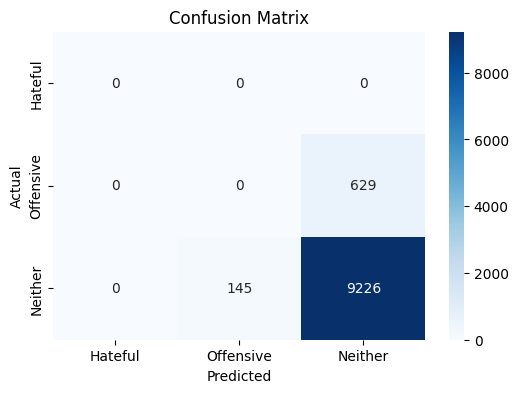

In [ ]:
#T5 output
from transformers import T5Tokenizer, T5ForConditionalGeneration
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import torch
from tqdm import tqdm

# Load dataset
df = pd.read_csv("/content/drive/MyDrive/hate/data/test_cleaned_final.csv")
df = df.rename(columns={"Offensive": "original_text", "Non-Offensive": "neutral_text"})
df = df[["original_text", "neutral_text"]].dropna()

# Load model and tokenizer
model_path = "/content/drive/MyDrive/hate/t5-rephrase-model"
tokenizer = T5Tokenizer.from_pretrained(model_path)
model = T5ForConditionalGeneration.from_pretrained(model_path)
model.eval()
model.to("cuda" if torch.cuda.is_available() else "cpu")

# Prepare inputs
BATCH_SIZE = 16
inputs = [f"rephrase: {t}" for t in df["original_text"].tolist()]
all_preds = []

# Batched inference
for i in tqdm(range(0, len(inputs), BATCH_SIZE)):
    batch = inputs[i:i+BATCH_SIZE]
    encodings = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=128)
    input_ids = encodings["input_ids"].to(model.device)
    attention_mask = encodings["attention_mask"].to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=128,
            num_beams=4,
            early_stopping=True
        )

    decoded = [tokenizer.decode(o, skip_special_tokens=True) for o in outputs]
    all_preds.extend(decoded)

# Heuristic label function (same as before)
def categorize(text):
    text = text.lower()
    if any(w in text for w in ["n****", "chink", "race", "ethnicity"]):
        return "Hateful"
    elif any(w in text for w in ["retarded", "idiot", "hoe"]):
        return "Offensive"
    else:
        return "Neither"

def categorize_pred(text):
    text = text.lower()
    if any(w in text for w in ["race", "ethnicity", "n****", "chink"]):
        return "Hateful"
    elif any(w in text for w in ["respect", "tone", "calm", "inclusive"]):
        return "Offensive"
    else:
        return "Neither"

# Assign labels
y_true = df["original_text"].apply(categorize).tolist()
y_pred = [categorize_pred(p) for p in all_preds]

# Evaluation
acc = accuracy_score(y_true, y_pred)
print(f"\nAccuracy: {acc:.2f}\n")
print("Classification Report:\n")
print(classification_report(y_true, y_pred, digits=2))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=["Hateful", "Offensive", "Neither"])
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=["Hateful", "Offensive", "Neither"],
            yticklabels=["Hateful", "Offensive", "Neither"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
!pip install gradio transformers --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 93.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.1 MB/s eta 0:00:00


In [ ]:
import gradio as gr
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModelForSeq2SeqLM
import torch
import torch.nn.functional as F

# Load hate speech classifier
print(" Loading classifier model...")
clf_model_path = "/content/drive/MyDrive/hate/roberta-hate-speech-model-20250501T060330Z-001/roberta-hate-speech-model"
clf_tokenizer = AutoTokenizer.from_pretrained(clf_model_path)
clf_model = AutoModelForSequenceClassification.from_pretrained(clf_model_path)
print(" Classifier loaded!")

# Load rephraser model
print("Loading rephraser model...")
reph_model_path = "/content/drive/MyDrive/hate/t5-rephrase-model"
reph_tokenizer = AutoTokenizer.from_pretrained(reph_model_path)
reph_model = AutoModelForSeq2SeqLM.from_pretrained(reph_model_path)
print("Rephraser loaded!")

label_map = {0: "Hateful", 1: "Neither", 2: "Offensive"}

def classify_and_rephrase(text, rephrase_option):
    # Step 1: Classification
    inputs = clf_tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = clf_model(**inputs)
        probs = F.softmax(outputs.logits, dim=1)
        confidence, prediction = torch.max(probs, dim=1)

    label_str = label_map[prediction.item()]
    confidence_pct = round(confidence.item() * 100, 2)
    prob_str = ", ".join(f"{label_map[i]}: {round(p * 100, 2)}%" for i, p in enumerate(probs[0].tolist()))

    response = f" Prediction:{label_str}\t Confidence: {confidence_pct}%\t Probabilities: {prob_str}"

    # Step 2: Optional Rephrasing
    if rephrase_option and label_str in ["Hateful", "Offensive"]:
        reph_input = reph_tokenizer(f"rephrase: {text}", return_tensors="pt", truncation=True, padding=True)
        reph_output = reph_model.generate(
            **reph_input,
            max_length=64,     # Reduced for speed
            num_beams=2,       # Reduced for speed
            early_stopping=True
        )
        rephrased_text = reph_tokenizer.decode(reph_output[0], skip_special_tokens=True)
        response += f"\n Rephrased Text: {rephrased_text}"

    return response

# Launch Gradio UI
gr.Interface(
    fn=classify_and_rephrase,
    inputs=[
        gr.Textbox(lines=3, placeholder="Enter a sentence to classify..."),
        gr.Checkbox(label="Also rephrase if hateful or offensive")
    ],
    outputs="markdown",
    title=" Hate Speech Classifier + Rephraser",
    description="Classifies text as Hateful, Offensive, or Neither. Optionally rephrases hateful/offensive text into neutral language.",
).launch()  # Remove share=True for speed


 Loading classifier model...
 Classifier loaded!
Loading rephraser model...
Rephraser loaded!
It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://50c5159cf6a9917ef2.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
!pip install transformers datasets scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 23.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [ ]:
import numpy as np
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score
from collections import Counter

In [ ]:
# Load dataset
dataset = load_dataset("Hate-speech-CNERG/hatexplain", trust_remote_code=True)

# Convert list of tokens into full text
def tokens_to_text(example):
    return {"text": " ".join(example["post_tokens"])}

for split in dataset:
    dataset[split] = dataset[split].map(tokens_to_text)

# Get majority vote label from annotators
#Problem: Each text has multiple annotations (3 annotators)
#Solution: Uses majority voting to create single labels
#Label Mapping:
#0: Normal
#1: Hate speech
#2: Offensive
def get_majority_label(example):
    label_list = example["annotators"]["label"]
    majority_label = Counter(label_list).most_common(1)[0][0]
    return {"labels": majority_label}

for split in dataset:
    dataset[split] = dataset[split].map(get_majority_label)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/10.1k [00:00<?, ?B/s]

hatexplain.py:   0%|          | 0.00/4.78k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/15383 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1922 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1924 [00:00<?, ? examples/s]

Map:   0%|          | 0/15383 [00:00<?, ? examples/s]

Map:   0%|          | 0/1922 [00:00<?, ? examples/s]

Map:   0%|          | 0/1924 [00:00<?, ? examples/s]

Map:   0%|          | 0/15383 [00:00<?, ? examples/s]

Map:   0%|          | 0/1922 [00:00<?, ? examples/s]

Map:   0%|          | 0/1924 [00:00<?, ? examples/s]

In [ ]:
# Load tokenizer and model (Vanilla BERT)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_function(example):
    return tokenizer(example["text"], truncation=True,#Cuts texts longer than 128 tokens
                     padding="max_length", max_length=128)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets.set_format(type="torch", columns=["input_ids", "attention_mask", #1 = Real token 0 = Padding token ([PAD])
"labels"])

train_dataset = tokenized_datasets["train"]
eval_dataset = tokenized_datasets["validation"]
test_dataset = tokenized_datasets["test"]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/15383 [00:00<?, ? examples/s]

Map:   0%|          | 0/1922 [00:00<?, ? examples/s]

Map:   0%|          | 0/1924 [00:00<?, ? examples/s]

In [ ]:
# Load BERT model
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
#BERT-base (12-layer, 768-hidden, 12-heads)

# Define metrics
def compute_metrics(pred):
    labels = pred.label_ids                   # True labels [0, 1, 2, ...]
    preds = np.argmax(pred.predictions, axis=1)  # Predicted classes
    acc = accuracy_score(labels, preds)       # Overall accuracy
    f1 = f1_score(labels, preds, average='weighted')  # Class-balanced F1
    return {"accuracy": acc, "f1": f1}

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir="./bert_results",         # Directory for checkpoints
    eval_strategy="epoch",              # Evaluate after each epoch
    save_strategy="epoch",              # Save model every epoch
    learning_rate=2e-5,                 # Standard LR for BERT fine-tuning
    per_device_train_batch_size=16,     # Batch size during training
    per_device_eval_batch_size=64,      # Larger batch for evaluation
    num_train_epochs=5,                 # Training duration
    weight_decay=0.01,                  # L2 regularization strength
    logging_dir="./bert_logs",          # TensorBoard log location
    logging_steps=10,                   # Log metrics every 10 steps
    load_best_model_at_end=True,        # Keep best model checkpoint
    metric_for_best_model="f1",         # Model selection metric
    greater_is_better=True,             # Higher F1 = better
    report_to="none",                   # Disable third-party logging
)

In [ ]:
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

<ipython-input-10-01d28cc5ee29>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.703700,0.720841,0.687825,0.665193
2,0.608000,0.712809,0.701873,0.699782
3,0.517800,0.841314,0.663371,0.665773
4,0.301000,1.005100,0.680021,0.684600
5,0.186700,1.157283,0.677419,0.678794


TrainOutput(global_step=4810, training_loss=0.4847017690942094, metrics={'train_runtime': 1768.0063, 'train_samples_per_second': 43.504, 'train_steps_per_second': 2.721, 'total_flos': 5059342131137280.0, 'train_loss': 0.4847017690942094, 'epoch': 5.0})

In [ ]:
trainer.save_model("/content/drive/MyDrive/hate/vanilla_bert1")
tokenizer.save_pretrained("/content/drive/MyDrive/hate/vanilla_bert1")


('/content/drive/MyDrive/hate/vanilla_bert1/tokenizer_config.json',
 '/content/drive/MyDrive/hate/vanilla_bert1/special_tokens_map.json',
 '/content/drive/MyDrive/hate/vanilla_bert1/vocab.txt',
 '/content/drive/MyDrive/hate/vanilla_bert1/added_tokens.json',
 '/content/drive/MyDrive/hate/vanilla_bert1/tokenizer.json')

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system ==

Classification Report:
              precision    recall  f1-score   support

     Hateful       0.75      0.81      0.78       593
     Neither       0.74      0.73      0.74       781
   Offensive       0.57      0.54      0.56       548

    accuracy                           0.70      1922
   macro avg       0.69      0.69      0.69      1922
weighted avg       0.70      0.70      0.70      1922



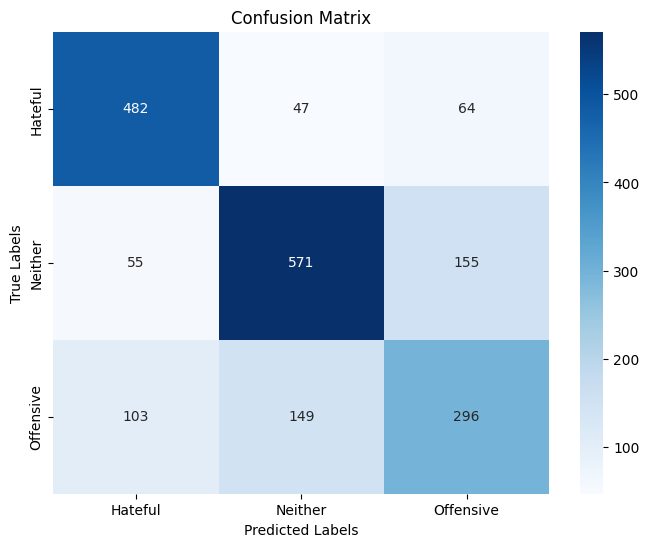

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Evaluate the model
eval_results = trainer.evaluate()

# Get the predictions and labels
predictions = trainer.predict(eval_dataset)
preds = np.argmax(predictions.predictions, axis=-1)
labels = predictions.label_ids

# Classification Report
report = classification_report(labels, preds, target_names=["Hateful", "Neither", "Offensive"], output_dict=True)
print("Classification Report:")
print(classification_report(labels, preds, target_names=["Hateful", "Neither", "Offensive"]))

# Confusion Matrix
cm = confusion_matrix(labels, preds)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Hateful", "Neither", "Offensive"], yticklabels=["Hateful", "Neither", "Offensive"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Optional: Save the classification report as a dictionary (for later use)
# You can access precision, recall, f1 score, etc., from the report dictionary


In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 9.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system =

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
from collections import Counter
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
import re, numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
!pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 62.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 39.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 45.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.1/204.1 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 955.6/9

In [ ]:
# Load HateXplain dataset from HuggingFace Hub
# trust_remote_code=True allows execution of dataset-specific loading scripts
dataset = load_dataset("Hate-speech-CNERG/hatexplain", trust_remote_code=True)

# Convert token lists to full text strings
def tokens_to_text(example):
    """Joins pre-tokenized text into continuous strings"""
    return {"text": " ".join(example["post_tokens"])}  # Example: ["This", "is"] → "This is"

# Aggregate multiple annotator labels via majority voting
def get_majority_label(example):
    """Determines consensus label from annotators"""
    label_list = example["annotators"]["label"]  # List of annotations (e.g., [0, 1, 1])
    majority_label = Counter(label_list).most_common(1)[0][0]  # Gets most frequent label
    return {"label": majority_label}  # Returns single label

# Apply preprocessing to all splits (train/validation/test)
for split in dataset:
    dataset[split] = dataset[split].map(tokens_to_text)  # First convert tokens → text
    dataset[split] = dataset[split].map(get_majority_label)  # Then aggregate labels

In [ ]:
# 3. Build vocab
# Initialize vocabulary with special tokens
word2idx = {"<pad>": 0, "<unk>": 1}  # Padding and unknown tokens
idx = 2  # Next available index

# Build vocabulary from training set
for example in dataset["train"]:
    for word in better_tokenizer(example["text"]):  # Process each token
        if word not in word2idx:  # Only add new words
            word2idx[word] = idx
            idx += 1

vocab_size = len(word2idx)  # Total unique tokens

# 4. Load GloVe
def load_glove(path, embedding_dim=100):
    """Loads pre-trained GloVe vectors from file"""
    glove = {}
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split()
            word = parts[0]  # The word
            vec = np.array(parts[1:], dtype=np.float32)  # Its vector
            glove[word] = vec
    return glove

# Load pre-trained embeddings
glove = load_glove("/content/drive/MyDrive/hate/glove.6B.100d.txt")

# Initialize embedding matrix (vocab_size × 100)
embedding_matrix = np.random.normal(
    scale=0.6,  # Standard deviation for random init
    size=(vocab_size, embedding_dim)
)

# Map vocabulary to GloVe vectors
for word, idx in word2idx.items():
    if word in glove:
        embedding_matrix[idx] = glove[word]  # Use pre-trained vector
    # Else: keeps random initialization


In [ ]:
def encode(text, max_len=100):
    # 1. Tokenization
    tokens = better_tokenizer(text)  # Applies your advanced tokenizer

    # 2. Vocabulary Lookup
    ids = [word2idx.get(t, word2idx["<unk>"]) for t in tokens]  # Word → ID

    # 3. Length Normalization
    ids = ids[:max_len]  # Truncate if exceeds max_len

    # 4. Padding
    ids += [word2idx["<pad>"]] * (max_len - len(ids))  # Pad if shorter

    # 5. Tensor Conversion
    return torch.tensor(ids)  # Convert to PyTorch tensor

In [ ]:
# 6. Dataset
class HateXplainCNNData(Dataset):
    def __init__(self, data):
        self.data = data  #  dataset split

    def __len__(self):
        return len(self.data)  # Required for DataLoader

    def __getitem__(self, idx):
        text = self.data[idx]["text"]  # Raw text
        label = self.data[idx]["label"]  # 0,1,2 (normal/hate/offensive)
        return encode(text), torch.tensor(label)  # (padded_ids, label)

train_dataset = HateXplainCNNData(dataset["train"])
val_dataset = HateXplainCNNData(dataset["validation"])
test_dataset = HateXplainCNNData(dataset["test"])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)


In [ ]:
# 7. CNN Model
class SimpleCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes, embedding_weights, kernel_sizes=[3,4,5], num_filters=128):
        super(SimpleCNN, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_weights, dtype=torch.float), freeze=False, padding_idx=0)
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embed_dim, out_channels=num_filters, kernel_size=k)
            for k in kernel_sizes
        ])
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(len(kernel_sizes) * num_filters, num_classes)

  def forward(self, x):
    # 1. Embedding lookup
    x = self.embedding(x)          # [32, 100, 100]

    # 2. Rearrange for Conv1D (channels first)
    x = x.permute(0, 2, 1)         # [32, 100, 100]

    # 3. Parallel convolution + ReLU
    x = [torch.relu(conv(x)) for conv in self.convs]
    # Now a list of [32, 128, seq_len-k+1] tensors

    # 4. Global max pooling
    x = [torch.max(c, dim=2)[0] for c in x]
    # List of [32, 128] tensors

    # 5. Concatenate features
    x = torch.cat(x, dim=1)        # [32, 384] (3*128)

    # 6. Dropout for regularization
    x = self.dropout(x)            # Randomly zero 30% of units

    # 7. Final classification
    return self.fc(x)              # [32, 3] (class logits)

In [ ]:
# 8. Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(
    vocab_size=vocab_size,          # From your vocabulary
    embed_dim=embedding_dim,        # 100 (matches GloVe)
    num_classes=3,                  # Normal/Hate/Offensive
    embedding_weights=embedding_matrix  # Your GloVe-enhanced matrix
).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()#Standard for multi-class classification
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',      # Monitor F1 (higher is better)
    factor=0.5,      # Halve LR when plateauing
    patience=1       # Wait 1 epoch before reducing
)

def evaluate(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(y.cpu().tolist())
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="weighted")
    return acc, f1

In [ ]:
best_f1 = 0  # Track best validation F1 for model selection

for epoch in range(20):
    # Training Phase
    model.train()
    total_loss = 0
    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        x, y = x.to(device), y.to(device)

        # 1. Forward Pass
        optimizer.zero_grad()
        logits = model(x)

        # 2. Loss Calculation (with class weighting)
        loss = loss_fn(logits, y)

        # 3. Backpropagation
        loss.backward()

        # Gradient Clipping (prevents exploding gradients)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 4. Weight Update
        optimizer.step()
        total_loss += loss.item()

    # Evaluation Phase
    val_acc, val_f1 = evaluate(model, val_loader)

    # Print Metrics
    print(f"Epoch {epoch+1} | Loss: {total_loss/len(train_loader):.4f} | "
          f"Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")

    # Learning Rate Scheduling
    scheduler.step(val_f1)  # Adjusts LR based on F1 plateau

    # Model Checkpointing
    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_f1': val_f1,
        }, "best_model.pt")
        print(f" Best model saved with F1: {val_f1:.4f}")

    # Early Stopping (optional)
    if epoch > 5 and val_f1 < best_f1 - 0.02:
        print(" Early stopping triggered!")
        break

# Final Model Save
torch.save(model.state_dict(), "/content/drive/MyDrive/hate/cnn-hate-speech-model_updated1.pt")
print("Model saved to Google Drive!")

Epoch 1: 100%|██████████| 481/481 [00:11<00:00, 41.51it/s]


Epoch 1 | Loss: 63.9584 | Val Acc: 0.6379 | Val F1: 0.6341
 Best model saved.


Epoch 2: 100%|██████████| 481/481 [00:12<00:00, 39.46it/s]


Epoch 2 | Loss: 46.1262 | Val Acc: 0.6311 | Val F1: 0.6303


Epoch 3: 100%|██████████| 481/481 [00:11<00:00, 41.07it/s]


Epoch 3 | Loss: 39.9253 | Val Acc: 0.6186 | Val F1: 0.6170


Epoch 4: 100%|██████████| 481/481 [00:11<00:00, 41.36it/s]


Epoch 4 | Loss: 32.1033 | Val Acc: 0.6228 | Val F1: 0.6232


Epoch 5: 100%|██████████| 481/481 [00:11<00:00, 40.10it/s]


Epoch 5 | Loss: 29.0189 | Val Acc: 0.6238 | Val F1: 0.6228


Epoch 6: 100%|██████████| 481/481 [00:11<00:00, 41.71it/s]


Epoch 6 | Loss: 26.2203 | Val Acc: 0.6264 | Val F1: 0.6236


Epoch 7: 100%|██████████| 481/481 [00:11<00:00, 42.21it/s]


Epoch 7 | Loss: 25.2146 | Val Acc: 0.6181 | Val F1: 0.6195


Epoch 8: 100%|██████████| 481/481 [00:11<00:00, 41.33it/s]


Epoch 8 | Loss: 24.0162 | Val Acc: 0.6233 | Val F1: 0.6223


Epoch 9: 100%|██████████| 481/481 [00:12<00:00, 39.37it/s]


Epoch 9 | Loss: 22.6042 | Val Acc: 0.6228 | Val F1: 0.6214


Epoch 10: 100%|██████████| 481/481 [00:11<00:00, 40.81it/s]


Epoch 10 | Loss: 22.1647 | Val Acc: 0.6238 | Val F1: 0.6220


Epoch 11: 100%|██████████| 481/481 [00:11<00:00, 42.01it/s]


Epoch 11 | Loss: 22.0496 | Val Acc: 0.6238 | Val F1: 0.6233


Epoch 12: 100%|██████████| 481/481 [00:11<00:00, 42.19it/s]


Epoch 12 | Loss: 21.5228 | Val Acc: 0.6233 | Val F1: 0.6220


Epoch 13: 100%|██████████| 481/481 [00:11<00:00, 43.01it/s]


Epoch 13 | Loss: 20.8715 | Val Acc: 0.6238 | Val F1: 0.6234


Epoch 14: 100%|██████████| 481/481 [00:11<00:00, 42.28it/s]


Epoch 14 | Loss: 20.7930 | Val Acc: 0.6243 | Val F1: 0.6232


Epoch 15: 100%|██████████| 481/481 [00:11<00:00, 42.30it/s]


Epoch 15 | Loss: 20.7387 | Val Acc: 0.6249 | Val F1: 0.6232


Epoch 16: 100%|██████████| 481/481 [00:11<00:00, 41.10it/s]


Epoch 16 | Loss: 20.7374 | Val Acc: 0.6249 | Val F1: 0.6243


Epoch 17: 100%|██████████| 481/481 [00:12<00:00, 39.47it/s]


Epoch 17 | Loss: 20.7671 | Val Acc: 0.6233 | Val F1: 0.6223


Epoch 18: 100%|██████████| 481/481 [00:11<00:00, 41.38it/s]


Epoch 18 | Loss: 20.9701 | Val Acc: 0.6228 | Val F1: 0.6218


Epoch 19: 100%|██████████| 481/481 [00:13<00:00, 36.00it/s]


Epoch 19 | Loss: 21.1288 | Val Acc: 0.6223 | Val F1: 0.6211


Epoch 20: 100%|██████████| 481/481 [00:12<00:00, 39.49it/s]


Epoch 20 | Loss: 20.4721 | Val Acc: 0.6228 | Val F1: 0.6216
Model saved to Google Drive!


Classification Report:

              precision    recall  f1-score   support

      Normal     0.6746    0.7189    0.6960       594
   Offensive     0.6889    0.6880    0.6884       782
        Hate     0.4647    0.4325    0.4480       548

    accuracy                         0.6247      1924
   macro avg     0.6094    0.6131    0.6108      1924
weighted avg     0.6206    0.6247    0.6223      1924



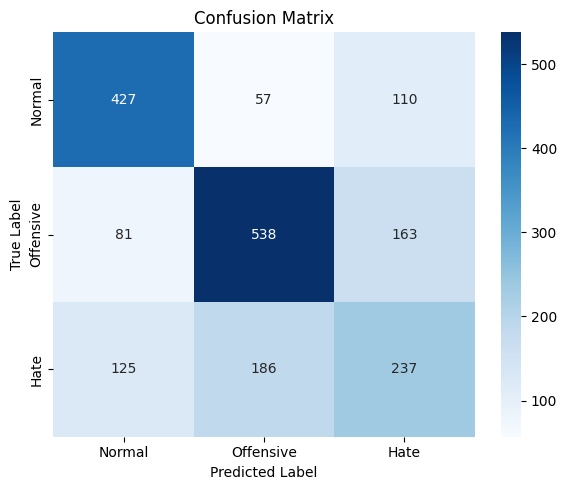

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load the best saved model
model.load_state_dict(torch.load("/content/drive/MyDrive/hate/cnn-hate-speech-model_updated1.pt"))
model.eval()

# Evaluation on test set
all_preds = []
all_labels = []

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(y.cpu().tolist())

# Generate classification report
target_names = ['Normal', 'Offensive', 'Hate']  # Change as per label mapping if needed
print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=target_names, digits=4))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


In [ ]:
# Install ftfy for fixing text encoding issues
!pip install -q ftfy

import pandas as pd
from ftfy import fix_text

# Load the previously uploaded CSV file
input_path = "/content/drive/MyDrive/hate/data/test_data_test.csv"
output_path_cleaned = "/content/drive/MyDrive/hate/data/test_data_cleaned.csv"

# Read CSV (attempt auto-detection of encoding and fix common issues)
df = pd.read_csv(input_path)

# Function to clean text: fix encoding, normalize whitespace, lowercase
def clean_text(text):
    if isinstance(text, str):
        fixed = fix_text(text)  # Fix mojibake and encoding
        fixed = fixed.lower()   # Lowercase
        fixed = ' '.join(fixed.split())  # Normalize whitespace
        return fixed
    return text

# Apply cleaning to all string columns
df_cleaned = df.applymap(clean_text)

# Save cleaned CSV
df_cleaned.to_csv(output_path_cleaned, index=False, encoding='utf-8')

output_path_cleaned


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.6 MB/s eta 0:00:00


<ipython-input-5-9cdc9d3cd8bf>:24: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_cleaned = df.applymap(clean_text)


'/content/drive/MyDrive/hate/data/test_data_cleaned.csv'

In [ ]:
import pandas as pd

# Load dataset
df = pd.read_csv("/content/drive/MyDrive/hate/data/test_data_cleaned.csv")
# Show basic info
print(df.columns)
print(df.head())


Index(['original_text', 'neutral_text'], dtype='object')
                             original_text  \
0                     that's so gay, dude.   
1  trans people are just confused weirdos.   
2              can't wait for the weekend!   
3      acting like a total spaz right now.   
4         women are too emotional to lead.   

                                        neutral_text  
0        that's a bit over-the-top, don't you think?  
1  it's important to respect everyone's identity,...  
2         looking forward to some rest this weekend!  
3    they're being very energetic and unpredictable.  
4  i think leadership should be based on individu...  


In [ ]:
# Rename columns for clarity
df = df.rename(columns={"Offensive": "original_text", "Non-Offensive": "neutral_text"})

# Drop unused columns
df = df[["original_text", "neutral_text"]].dropna()

# Preview cleaned data
df.head()


,original_text,neutral_text
0,"that's so gay, dude.","that's a bit over-the-top, don't you think?"
1,trans people are just confused weirdos.,"it's important to respect everyone's identity,..."
2,can't wait for the weekend!,looking forward to some rest this weekend!
3,acting like a total spaz right now.,they're being very energetic and unpredictable.
4,women are too emotional to lead.,i think leadership should be based on individu...


In [ ]:
!pip install transformers datasets sentencepiece --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12=

In [ ]:
import pandas as pd
from datasets import Dataset

# Load cleaned data
df = pd.read_csv("/content/drive/MyDrive/hate/data/test_data_cleaned.csv")[["original_text", "neutral_text"]] # Use the new column names: 'original_text', 'neutral_text'

# Optional: Add task prefix
df["original_text"] = "rephrase: " + df["original_text"]

# Convert to HuggingFace Dataset
dataset = Dataset.from_pandas(df[["original_text", "neutral_text"]])
dataset = dataset.train_test_split(test_size=0.1)  # 90% train, 10% test

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("t5-small")

def tokenize(batch):
    return tokenizer(batch["original_text"], padding="max_length", truncation=True, max_length=128)

def tokenize_labels(batch):
    labels = tokenizer(batch["neutral_text"], padding="max_length", truncation=True, max_length=128)
    batch["labels"] = labels["input_ids"]
    return batch

dataset = dataset.map(tokenize)
dataset = dataset.map(tokenize_labels)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Map:   0%|          | 0/9018 [00:00<?, ? examples/s]

Map:   0%|          | 0/1002 [00:00<?, ? examples/s]

Map:   0%|          | 0/9018 [00:00<?, ? examples/s]

Map:   0%|          | 0/1002 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoModelForSeq2SeqLM, TrainingArguments, Trainer
import os
os.environ["WANDB_DISABLED"] = "true"

model = AutoModelForSeq2SeqLM.from_pretrained("t5-small")

training_args = TrainingArguments(
    output_dir="./t5_rephrase_model",
    num_train_epochs=5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=10,
    learning_rate=5e-5,
    weight_decay=0.01,
    save_total_limit=2,
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=tokenizer
)

trainer.train()


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-14-de741f3d0c40>:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss
1,0.003500,0.000335
2,0.001000,0.000018
3,0.001200,0.000007
4,0.000200,0.000004
5,0.000100,0.000003


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


TrainOutput(global_step=11275, training_loss=0.031040717153691225, metrics={'train_runtime': 1239.3583, 'train_samples_per_second': 36.382, 'train_steps_per_second': 9.097, 'total_flos': 1525640457093120.0, 'train_loss': 0.031040717153691225, 'epoch': 5.0})

In [ ]:
trainer.save_model("/content/drive/MyDrive/hate/t5-rephrase-model1")
tokenizer.save_pretrained("/content/drive/MyDrive/hate/t5-rephrase-model1")


('/content/drive/MyDrive/hate/t5-rephrase-model1/tokenizer_config.json',
 '/content/drive/MyDrive/hate/t5-rephrase-model1/special_tokens_map.json',
 '/content/drive/MyDrive/hate/t5-rephrase-model1/spiece.model',
 '/content/drive/MyDrive/hate/t5-rephrase-model1/added_tokens.json',
 '/content/drive/MyDrive/hate/t5-rephrase-model1/tokenizer.json')

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
100%|██████████| 627/627 [03:17<00:00,  3.18it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.


Accuracy: 0.90

Classification Report:

              precision    recall  f1-score   support

     Hateful       0.00      0.00      0.00         0
     Neither       1.00      0.90      0.95     10020
   Offensive       0.00      0.00      0.00         0

    accuracy                           0.90     10020
   macro avg       0.33      0.30      0.32     10020
weighted avg       1.00      0.90      0.95     10020



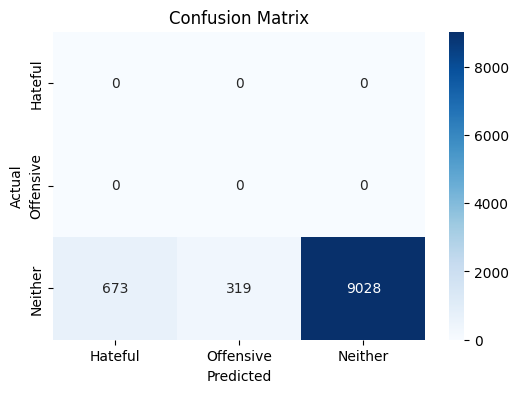

In [ ]:
#T5 output
from transformers import T5Tokenizer, T5ForConditionalGeneration
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import torch
from tqdm import tqdm

# Load dataset
df = pd.read_csv("/content/drive/MyDrive/hate/data/test_data_cleaned.csv")
df = df.rename(columns={"Offensive": "original_text", "Non-Offensive": "neutral_text"})
df = df[["original_text", "neutral_text"]].dropna()

# Load model and tokenizer
model_path = "/content/drive/MyDrive/hate/t5-rephrase-model1"
tokenizer = T5Tokenizer.from_pretrained(model_path)
model = T5ForConditionalGeneration.from_pretrained(model_path)
model.eval()
model.to("cuda" if torch.cuda.is_available() else "cpu")

# Prepare inputs
BATCH_SIZE = 16
inputs = [f"rephrase: {t}" for t in df["original_text"].tolist()]
all_preds = []

# Batched inference
for i in tqdm(range(0, len(inputs), BATCH_SIZE)):
    batch = inputs[i:i+BATCH_SIZE]
    encodings = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=128)
    input_ids = encodings["input_ids"].to(model.device)
    attention_mask = encodings["attention_mask"].to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=128,
            num_beams=4,
            early_stopping=True
        )

    decoded = [tokenizer.decode(o, skip_special_tokens=True) for o in outputs]
    all_preds.extend(decoded)

# Heuristic label function (same as before)
def categorize(text):
    text = text.lower()
    if any(w in text for w in ["n****", "chink", "race", "ethnicity"]):
        return "Hateful"
    elif any(w in text for w in ["retarded", "idiot", "hoe"]):
        return "Offensive"
    else:
        return "Neither"

def categorize_pred(text):
    text = text.lower()
    if any(w in text for w in ["race", "ethnicity", "n****", "chink"]):
        return "Hateful"
    elif any(w in text for w in ["respect", "tone", "calm", "inclusive"]):
        return "Offensive"
    else:
        return "Neither"

# Assign labels
y_true = df["original_text"].apply(categorize).tolist()
y_pred = [categorize_pred(p) for p in all_preds]

# Evaluation
acc = accuracy_score(y_true, y_pred)
print(f"\nAccuracy: {acc:.2f}\n")
print("Classification Report:\n")
print(classification_report(y_true, y_pred, digits=2))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=["Hateful", "Offensive", "Neither"])
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=["Hateful", "Offensive", "Neither"],
            yticklabels=["Hateful", "Offensive", "Neither"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
!pip install gradio transformers --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 101.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.1 MB/s eta 0:00:00


In [2]:
import gradio as gr
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModelForSeq2SeqLM
import torch
import torch.nn.functional as F

# Load hate speech classifier
print(" Loading classifier model...")
clf_model_path = "/content/drive/MyDrive/hate/roberta-hate-speech-model-20250501T060330Z-001/roberta-hate-speech-model"
clf_tokenizer = AutoTokenizer.from_pretrained(clf_model_path)
clf_model = AutoModelForSequenceClassification.from_pretrained(clf_model_path)
print(" Classifier loaded!")

# Load rephraser model
print("Loading rephraser model...")
reph_model_path = "/content/drive/MyDrive/hate/t5-rephrase-model1"
reph_tokenizer = AutoTokenizer.from_pretrained(reph_model_path)
reph_model = AutoModelForSeq2SeqLM.from_pretrained(reph_model_path)
print("Rephraser loaded!")

label_map = {0: "Hateful", 1: "Neither", 2: "Offensive"}

def classify_and_rephrase(text, rephrase_option):
    # Step 1: Classification
    inputs = clf_tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = clf_model(**inputs)
        probs = F.softmax(outputs.logits, dim=1)
        confidence, prediction = torch.max(probs, dim=1)

    label_str = label_map[prediction.item()]
    confidence_pct = round(confidence.item() * 100, 2)
    prob_str = ", ".join(f"{label_map[i]}: {round(p * 100, 2)}%" for i, p in enumerate(probs[0].tolist()))

    response = f" Prediction:{label_str}\t Confidence: {confidence_pct}%\t Probabilities: {prob_str}"

    # Step 2: Optional Rephrasing
    if rephrase_option and label_str in ["Hateful", "Offensive"]:
        reph_input = reph_tokenizer(f"rephrase: {text}", return_tensors="pt", truncation=True, padding=True)
        reph_output = reph_model.generate(
            **reph_input,
            max_length=64,     # Reduced for speed
            num_beams=2,       # Reduced for speed
            early_stopping=True
        )
        rephrased_text = reph_tokenizer.decode(reph_output[0], skip_special_tokens=True)
        response += f"\n Rephrased Text: {rephrased_text}"

    return response

# Launch Gradio UI
gr.Interface(
    fn=classify_and_rephrase,
    inputs=[
        gr.Textbox(lines=3, placeholder="Enter a sentence to classify..."),
        gr.Checkbox(label="Also rephrase if hateful or offensive")
    ],
    outputs="markdown",
    title=" Hate Speech Classifier + Rephraser",
    description="Classifies text as Hateful, Offensive, or Neither. Optionally rephrases hateful/offensive text into neutral language.",
).launch()  # Remove share=True for speed


 Loading classifier model...
 Classifier loaded!
Loading rephraser model...
Rephraser loaded!
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://1d7faa7c8fc7107ac8.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
